In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [2]:
count_data = np.array([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  11,
    19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  19,  23,
    27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  15,  15,  19,
    70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  12,  35,  17,  23,
    17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   5,  14,  13,  22,
], dtype=np.float32)

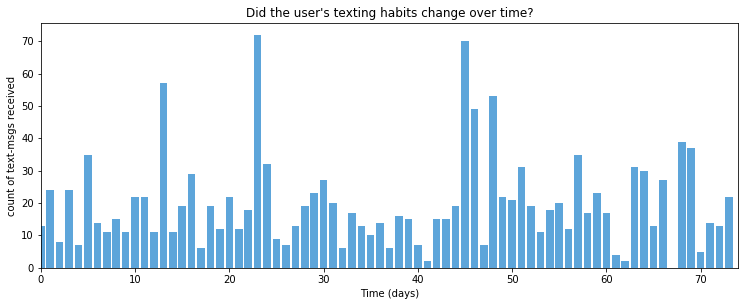

In [3]:
figsize(12.5, 4.5)
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [5]:

def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
  
    alpha = np.array(1. / count_data.mean(), np.float32)
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
  
    rv_tau = tfd.Uniform()
  
    lambda_ = tf.gather(
        [lambda_1, lambda_2],
        indices=tf.to_int32(tau * count_data.size <= np.arange(count_data.size)))
    rv_observation = tfd.Poisson(rate=lambda_)
  
    return (
        rv_lambda_1.log_prob(lambda_1)
        + rv_lambda_2.log_prob(lambda_2)
        + rv_tau.log_prob(tau)
        + tf.reduce_sum(rv_observation.log_prob(count_data))
    )

In [6]:
# Set the chain's start state.
initial_chain_state = [
    count_data.mean() * tf.ones([], dtype=np.float32, name="init_lambda1"),
    count_data.mean() * tf.ones([], dtype=np.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=np.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)


# Initialize the step_size. (It will be automatically adapted.)
step_size = tf.get_variable(
    name='step_size',
    initializer=np.array(0.05, dtype=np.float32),
    trainable=False)


# Sample from the chain.
[
    posterior_lambda_1,
    posterior_lambda_2,
    posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
    num_results=int(10e3),
    num_burnin_steps=int(1e3),
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors))


# Initialize any created variables.
init_op = tf.global_variables_initializer()

In [7]:
with tf.Session() as sess:
    init_op.run()
    [
        posterior_lambda_1_,
        posterior_lambda_2_,
        posterior_tau_,
        kernel_results_,
    ] = sess.run([
        posterior_lambda_1,
        posterior_lambda_2,
        posterior_tau,
        kernel_results,
    ])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.5841
final step size: 0.03163638710975647


In [8]:
# Convert our samples to what the book's code expects.
lambda_1_samples = posterior_lambda_1_
lambda_2_samples = posterior_lambda_2_
tau_samples = np.array(np.floor(posterior_tau_ * count_data.size),
                       dtype=np.int32)

<>:8: DeprecationWarning: invalid escape sequence \l
<>:13: DeprecationWarning: invalid escape sequence \l
<>:18: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \l
<>:8: DeprecationWarning: invalid escape sequence \l
<>:13: DeprecationWarning: invalid escape sequence \l
<>:18: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \l
<>:8: DeprecationWarning: invalid escape sequence \l
<>:13: DeprecationWarning: invalid escape sequence \l
<>:18: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \l
<ipython-input-9-8e5b8c205a57>:8: DeprecationWarning: invalid escape sequence \l
  label="posterior of $\lambda_1$", color="#A60628", normed=True)
<ipython-input-9-8e5b8c205a57>:13: DeprecationWarning: invalid escape sequence \l
  plt.xlabel("$\lambda_1$ value")
<ipython-input-9-8e5b8c205a57>:18: DeprecationWarning: invalid escape sequence \l
  label="p

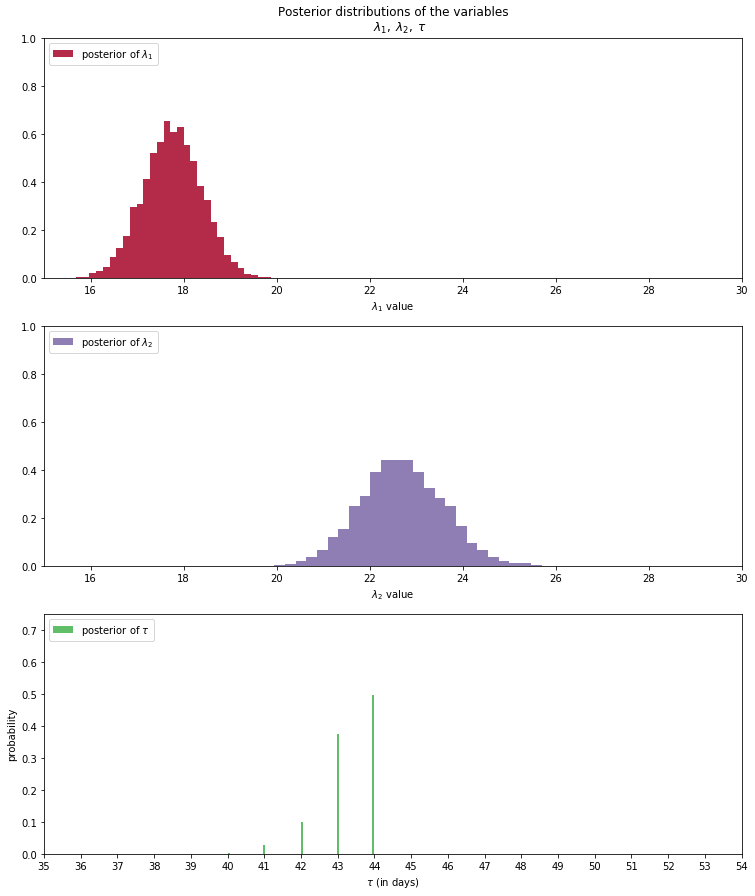

In [9]:
figsize(12.5, 15)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#60BD68", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");